Title + Description

In [1]:
import os
import glob
import shutil
import pandas as pd
import re

from Bio.PDB import PDBList
from pathlib import Path
from Bio.PDB import PDBParser, NeighborSearch, PDBIO, Superimposer
from Bio.SeqUtils import seq1

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Download

In [ ]:
def download_pdb(pdb_id, out_dir="pdbs"):
    """
    Download a PDB structure from RCSB.
    """
    pdb_id = pdb_id.lower()
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    try:
        pdbl = PDBList()
        raw_path = pdbl.retrieve_pdb_file(
            pdb_id,
            pdir=str(out_dir),
            file_format='pdb',
            overwrite=True
        )

        raw_path = Path(raw_path)
        clean_path = out_dir / f"{pdb_id}.pdb"
        raw_path.rename(clean_path)
    
    except Exception as e:
        print(f"[ERROR] Could not download {pdb_id}: {e}")
        return None


In [ ]:
df = pd.read_csv('tcr_pdbs_david.csv', sep=';')
outdir = 'pdbs' # directory for downloaded pdb files

for _, row in df.iterrows():
    # download PDB
    download_pdb(row.PDB, outdir)

# Annotate Chains

In [ ]:
def get_chain_sequences(pdb_file):
    """ 
    Create dictionary with all chain ids and the corresponding sequence. 
    """

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('tcr', pdb_file)
    
    chain_seqs = {}
    for chain in structure.get_chains():
        residues = [
            res for res in chain
            if res.id[0] == " "  # exclude hetero/water
        ]
        if not residues:
            continue
        
        seq = "".join(seq1(res.resname) for res in residues)
        chain_seqs[chain.id] = seq

    return chain_seqs

def find_epitope_chains(chain_seqs, epitope):
    return [
        cid for cid, seq in chain_seqs.items()
        if seq.upper() == epitope.upper()
    ]

def find_tcr_chains_by_cdr(chain_seqs, cdrs):
    hits = []
    for chain_id, seq in chain_seqs.items():
        n_hits = sum(cdr.lower() in seq.lower() for cdr in cdrs)
        if n_hits >= 2:
            hits.append(chain_id)
    return hits

def is_beta2m(seq):
    return 85 <= len(seq) <= 120

def find_mhci_alpha_from_beta2m(chain_seqs, beta2m_ids, excluded_ids):
    """
    Infer MHC-I alpha as remaining extracellular chains once beta2m is known.
    Returns only chain IDs (not seqs).
    """
    candidates = [
        (cid, seq)
        for cid, seq in chain_seqs.items()
        if cid not in excluded_ids
        and cid not in beta2m_ids
        and len(seq) >= 250
    ]
    # return only the chain IDs
    return [cid for cid, seq in candidates]


def chains_in_contact_count(structure, ref_chain_id, candidate_chain_ids, cutoff=8.0):
    """
    Helper to get chains with maximal contacts to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]
    # unfold all C-alpha atoms in the reference chain
    ref_atoms = [atom for res in ref_chain for atom in res if atom.get_name() == 'CA']

    # all C-alpha atoms in the structure
    all_atoms = [atom for chain in model for res in chain for atom in res if atom.get_name() == 'CA']
    ns = NeighborSearch(all_atoms)

    counts = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [atom for res in model[cid] for atom in res if atom.get_name() == 'CA']
        contact_atoms = set()
        for atom in candidate_atoms:
            neighbors = ns.search(atom.coord, cutoff)
            # count only neighbors in ref_atoms
            if any(n in ref_atoms for n in neighbors):
                contact_atoms.add(atom)
        counts[cid] = len(contact_atoms)

    return counts


def min_ca_distance(structure, ref_chain_id, candidate_chain_ids):
    """
    Helper to get chains with minimum CA distance to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]

    ref_atoms = [
        atom for res in ref_chain
        for atom in res if atom.get_name() == 'CA'
    ]

    distances = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [
            atom for res in model[cid]
            for atom in res if atom.get_name() == 'CA'
        ]
        if not candidate_atoms:
            distances[cid] = np.inf
            continue

        min_dist = min(
            np.linalg.norm(a.coord - b.coord)
            for a in candidate_atoms
            for b in ref_atoms
        )
        distances[cid] = min_dist

    return distances



def select_first_complex(structure, chain_seqs, row):
    # 1. pick epitope with lowest chain ID
    epitope_chains = find_epitope_chains(chain_seqs, row.epitope)
    if not epitope_chains:
        return {}
    epitope_chain = sorted(epitope_chains)[0]

    remaining = {cid: seq for cid, seq in chain_seqs.items() if cid != epitope_chain}

    # 2. pick TCR alpha/beta chains with most contacts (or smallest distance)
    tcr_alpha_candidates = find_tcr_chains_by_cdr(remaining, [row.CDR1A,row.CDR2A,row.CDR3A])
    tcr_beta_candidates  = find_tcr_chains_by_cdr(remaining, [row.CDR1B,row.CDR2B,row.CDR3B])
    
    tcr_alpha_counts = chains_in_contact_count(structure, epitope_chain, tcr_alpha_candidates)
    tcr_beta_counts  = chains_in_contact_count(structure, epitope_chain, tcr_beta_candidates)
    
    # TCR alpha
    if tcr_alpha_counts and max(tcr_alpha_counts.values()) > 0:
        tcr_alpha_chain = max(tcr_alpha_counts, key=tcr_alpha_counts.get)
    elif tcr_alpha_candidates:
        alpha_distances = min_ca_distance(structure, epitope_chain, tcr_alpha_candidates)
        tcr_alpha_chain = min(alpha_distances, key=alpha_distances.get)
    else:
        tcr_alpha_chain = None

    # TCR beta
    if tcr_beta_counts and max(tcr_beta_counts.values()) > 0:
        tcr_beta_chain = max(tcr_beta_counts, key=tcr_beta_counts.get)
    elif tcr_beta_candidates:
        beta_distances = min_ca_distance(structure, epitope_chain, tcr_beta_candidates)
        tcr_beta_chain = min(beta_distances, key=beta_distances.get)
    else:
        tcr_beta_chain = None


    used_ids = set(epitope_chains + tcr_alpha_candidates + tcr_beta_candidates)

    # 3. MHC chains: split remaining into candidates
    remaining = {cid: seq for cid, seq in remaining.items() if cid not in used_ids}

    # MHC-I: look for beta2m first
    beta2m_candidates = [cid for cid, seq in remaining.items() if is_beta2m(seq)]

    if beta2m_candidates:
        # MHC-I 
        mhci_alpha_candidates = [cid for cid in remaining if cid not in beta2m_candidates]
        
        # count contacts to epitope
        mhci_alpha_counts = chains_in_contact_count(structure, epitope_chain, mhci_alpha_candidates)
        mhci_alpha_chain = max(mhci_alpha_counts, key=mhci_alpha_counts.get)
        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhci_alpha_chain': mhci_alpha_chain,
        }
    else:
        # MHC-II
        mhcii_candidates = [cid for cid, seq in remaining.items()]

        if len(mhcii_candidates) < 2:
            return {}

        mhcii_counts = chains_in_contact_count(
            structure, epitope_chain, mhcii_candidates
        )

        # get the two chains with the highest contact counts
        top_two = sorted(
            mhcii_counts.items(),
            key=lambda x: x[1],
            reverse=True)[:2]

        # order those two by chain ID
        chain_ids = sorted(cid for cid, _ in top_two)
        mhcii_alpha, mhcii_beta = chain_ids[0], chain_ids[1]


        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhcii_alpha_chain': mhcii_alpha,
            'mhcii_beta_chain': mhcii_beta
        }

    return roles



In [37]:
df = pd.read_csv('tcr_pdbs_david.csv', sep=';')
test = ['6uon']
#df = df[df['PDB'].isin(test)]
outdir = 'pdbs' # directory for downloaded pdb files

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(outdir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        continue

    chain_seqs = get_chain_sequences(pdb_file)
    structure = PDBParser(QUIET=True).get_structure('tcr', pdb_file)

    roles = select_first_complex(structure, chain_seqs, row)
    
    for col, cid in roles.items():
        df.at[idx, col] = cid

df.to_csv('tcr_pdbs_chains_david.csv', sep=';', index=False)
    

# Clean PDBs 

In [ ]:
from Bio.PDB import Structure, Model, Chain

def clean_chains(pdb_file, chain_mapping, out_file):
    """
    Keep only specified chains, rename them, and remove water/ions/ligands.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    # create new structure
    new_structure = Structure.Structure(structure.id)
    new_model = Model.Model(0)
    new_structure.add(new_model)

    model = structure[0]

    for old_chain_id, new_chain_id in chain_mapping.items():
        if old_chain_id not in model:
            continue  # skip missing chains
        old_chain = model[old_chain_id]

        # create new chain
        new_chain = Chain.Chain(new_chain_id)

        for residue in old_chain:
            # skip water and hetero residues
            if residue.id[0] != ' ':
                continue
            new_chain.add(residue.copy())

        new_model.add(new_chain)

    # save cleaned PDB
    io = PDBIO()
    io.set_structure(new_structure)
    io.save(out_file)


In [ ]:
df = pd.read_csv('tcr_pdbs_chains_david.csv', sep=';')

indir = 'pdbs'
outdir = 'pdbs_clean'
os.makedirs(outdir, exist_ok=True)

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(indir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        continue

    chain_mapping = {}
    if pd.notna(row.mhci_alpha_chain):
        chain_mapping[row.mhci_alpha_chain] = 'A'
    if pd.notna(row.mhcii_alpha_chain):
        chain_mapping[row.mhcii_alpha_chain] = 'A'
    if pd.notna(row.mhcii_beta_chain):
        chain_mapping[row.mhcii_beta_chain] = 'B'
    if pd.notna(row.epitope_chain):
        chain_mapping[row.epitope_chain] = 'C'
    if pd.notna(row.tcr_alpha_chain):
        chain_mapping[row.tcr_alpha_chain] = 'D'
    if pd.notna(row.tcr_beta_chain):
        chain_mapping[row.tcr_beta_chain] = 'E'

    clean_chains(pdb_file, chain_mapping, out_file=os.path.join(outdir, f'{row.PDB}.pdb'))

# Align MHC-I complexes

In [3]:
def align_pdbs(ref_file, mobile_files, output_dir):
    parser = PDBParser(QUIET=True)
    io = PDBIO()

    # Load reference structure (first pdb)
    ref_structure = parser.get_structure("ref", ref_file)
    ref_chain = ref_structure[0]["A"]
    ref_atoms = list(chain for chain in ref_chain.get_atoms() if chain.get_name() == "CA")[:180]

    # Align all other PDBs to reference
    for pdb_path in mobile_files:
        structure = parser.get_structure(os.path.basename(pdb_path), pdb_path)
        chain = structure[0]["A"]
        moving_atoms = list(atom for atom in chain.get_atoms() if atom.get_name() == "CA")[:180]
        
        # Superimpose
        sup = Superimposer()
        sup.set_atoms(ref_atoms, moving_atoms)
        sup.apply(structure.get_atoms())

        # Save aligned PDB
        out_path = os.path.join(output_dir, os.path.basename(pdb_path))
        io.set_structure(structure)
        io.save(out_path)
        print(f"Aligned {pdb_path} -> {out_path}")



In [ ]:
parser = PDBParser(QUIET=True)

indir = 'pdbs_clean'
outdir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()

# Select MHC-I complexes
pdbs_mhci = []
for pdb_file in pdbs:
    structure = parser.get_structure(os.path.basename(pdb_file), pdb_file)
    model = structure[0]
    chain_ids = [chain.id for chain in model]
    
    if 'B' not in chain_ids:
        pdbs_mhci.append(pdb_file)

# Example usage
os.makedirs(outdir, exist_ok=True)

ref_file = pdbs_mhci[0]
# Save reference to output directory
ref_out_path = os.path.join(outdir, os.path.basename(ref_file))
shutil.copy(ref_file, ref_out_path)

# Align remaining files to reference
mobile_files = pdbs_mhci[1:]
align_pdbs(ref_file, mobile_files, outdir)



pdbs_mhci_align/1ao7.pdb


# PCA on CDRs

In [117]:
def get_chain_sequence(pdb_file, chain_id):
    """
    Get sequence based on chain id.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("tcr", pdb_file)

    seq = []
    for res in structure[0][chain_id]: 
        seq.append(seq1(res.get_resname()))

    return "".join(seq)


def extract_cdr3(sequence, min_len=7, max_len=23):
    """
    Extract CDR3 using conserved C (start) and the F/W-GxG motif (end). Ensures min_len <= CDR3 length <= max_len.
    """
    # find all conserved C positions
    c_positions = [m.start() for m in re.finditer("C", sequence)]
    if not c_positions:
        return None

    # try Cs from last to first (most likely real CDR3 start)
    for c_pos in reversed(c_positions):
        subseq = sequence[c_pos:]

        # find all FGXG / WGXG motifs after this C
        matches = list(re.finditer(r"([FW])G.G", subseq))
        if not matches:
            continue

        # check motifs from LAST to FIRST
        for match in reversed(matches):
            end = c_pos + match.start(1) + 1
            cdr3 = sequence[c_pos:end]

            L = len(cdr3)
            if min_len <= L <= max_len:
                return cdr3

    return None

def extract_cdr_coords(pdb_path, cdr_dict, chain_map={"TRA":"A","TRB":"B"}):
    """
    Extract coordinates of CDRs based on the respective sequences.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", pdb_path)
    
    cdr_coords = {}
    
    for chain_label, chain_id in chain_map.items():
        chain_obj = structure[0][chain_id]
        
        # Get all residues with C-alpha
        residues = [res for res in chain_obj if res.id[0] == " " and "CA" in res]
        seq = "".join([res.get_resname() for res in residues])
        # Convert 3-letter PDB codes to 1-letter
        seq = "".join([seq1(res.get_resname()) for res in residues])
        
        cdr_coords[chain_label] = {}
        
        # loop over CDR1/2/3
        for i, cdr_key in enumerate([f"CDR1{chain_label[-1]}", f"CDR2{chain_label[-1]}", f"CDR3{chain_label[-1]}"], 1):
            cdr_seq = cdr_dict[cdr_key].upper()
            L = len(cdr_seq)
            
            # find CDR sequence in the chain sequence
            start_idx = seq.find(cdr_seq)
            if start_idx == -1:
                print(f"Warning: CDR {cdr_key} sequence not found in chain {chain_id} of {pdb_path}")
                # fallback: take first L residues
                start_idx = 0
            end_idx = start_idx + L
            
            # extract C-alpha coordinates
            coords = np.array([res["CA"].get_coord() for res in residues[start_idx:end_idx]])
            cdr_coords[chain_label][f"cdr{i}"] = coords
            
    return cdr_coords


def build_coord_matrix(cdr_coord_dict, min_cdr_lengths):
    """
    Build coordinate matrix with fixed-length CDRs.
    """
    coord_matrix = []
    for tcr, chains in cdr_coord_dict.items():
        vec = []
        for chain, cdrs in chains.items():
            for cdr_name in ["cdr1","cdr2"]:
                coords = cdrs[cdr_name]
                L = min_cdr_lengths[chain][cdr_name]
                # first 2 + last L-2
                selected = np.vstack([coords[:2], coords[-(L-2):]])
                vec.extend(selected.flatten())
            # CDR3: first 5 + last L-5
            coords = cdrs["cdr3"]
            L = min_cdr_lengths[chain]["cdr3"]
            selected = np.vstack([coords[:5], coords[-(L-5):]])
            vec.extend(selected.flatten())
        coord_matrix.append(vec)
    
    return np.array(coord_matrix)


In [136]:
# fix CDR3 sequences
df = pd.read_csv('tcr_pdbs_chains_david.csv', sep=';')
indir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()

fixed_rows = []
for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    row = df[df["PDB"] == pdb_id]

    row = row.iloc[0].copy()

    # get TCR chains
    seq_a = get_chain_sequence(pdb_file, "D")
    seq_b = get_chain_sequence(pdb_file, "E")

    # extract correct CDRs
    cdr3a_fix = extract_cdr3(seq_a)
    cdr3b_fix = extract_cdr3(seq_b)

    row["CDR3A_fix"] = cdr3a_fix
    row["CDR3B_fix"] = cdr3b_fix

    if (cdr3a_fix is None) | (cdr3b_fix is None):
        print(f'Error: CDR3 not found for PDB id. {pdb_id}')
        continue

    fixed_rows.append(row)

df_fixed = pd.DataFrame(fixed_rows)
df_fixed.to_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';', index=False)

Error: CDR3 not found for PDB id. 3vxu


In [ ]:
df = pd.read_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';')
indir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()
pdbs = [p for p in pdbs if os.path.basename(p.split('.')[0]) in df['PDB'].values]

cdr_coord_dict = {}
for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    
    # exctract CDR coordinates
    row = df[df["PDB"] == pdb_id]
    cdr_dict = {cdr: str(row[cdr].values[0]).upper() for cdr in ["CDR1A","CDR2A","CDR3A_fix","CDR1B","CDR2B","CDR3B_fix"]}
    cdr_dict['CDR3A'] = cdr_dict.pop('CDR3A_fix') # rename dict keys
    cdr_dict['CDR3B'] = cdr_dict.pop('CDR3B_fix')

    cdr_coords = extract_cdr_coords(pdb_file, cdr_dict, chain_map={"TRA":"D","TRB":"E"})
    cdr_coord_dict[pdb_id] = cdr_coords

# minimal CDR lengths
min_cdr_lengths = {}
for chain_label in ["TRA","TRB"]:
    min_cdr_lengths[chain_label] = {}
    for cdr_name in ["cdr1","cdr2","cdr3"]:
        min_len = min(cdr_coord_dict[pdb_id][chain_label][cdr_name].shape[0] 
                    for pdb_id in cdr_coord_dict)
        min_cdr_lengths[chain_label][cdr_name] = min_len
print(min_cdr_lengths)

# build coordinate matrix and perform pca
coord_matrix = build_coord_matrix(cdr_coord_dict, min_cdr_lengths)
pca = PCA(n_components=2)
pcs = pca.fit_transform(coord_matrix)

df_pca = pd.DataFrame()
df_pca['PC1'] = pcs[:,0]
df_pca['PC2'] = pcs[:,1]
df_pca['PDB'] = np.array(pdbs)
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])

df_merged = pd.merge(df, df_pca, on='PDB')
df_merged.to_csv('tcr_pdbs_chains_david_mhci_pca.csv', sep=';', index=False)

{'TRA': {'cdr1': 5, 'cdr2': 4, 'cdr3': 10}, 'TRB': {'cdr1': 5, 'cdr2': 5, 'cdr3': 11}}


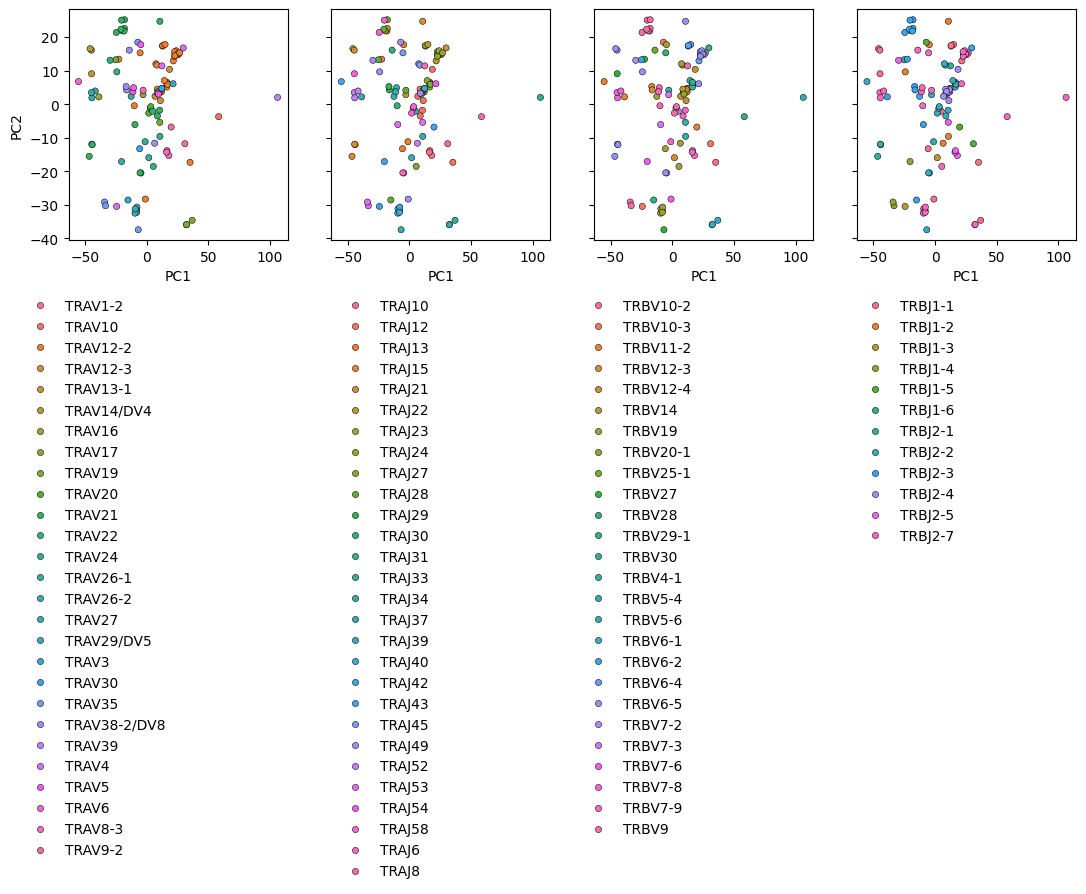

In [167]:
df = pd.read_csv('tcr_pdbs_chains_david_mhci_pca.csv', sep=';')

fig, axes = plt.subplots(1, 4, figsize=(13,3), sharex=True, sharey=True)

segments = ['TRAV', 'TRAJ', 'TRBV', 'TRBJ']

for cnt, seg in enumerate(segments):
    ax = axes[cnt]
    df = df.sort_values(by=seg)
    sns.scatterplot(df, x='PC1', y='PC2', hue=seg, ax=ax, edgecolor='black', s=20)
    ax.legend(bbox_to_anchor=(0.5,-0.2), frameon=False)

# Projection of AF3 models

## Align models

In [4]:
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

# align AF3 model to experimental stuctures with lowest pdb id. 
tmp = glob.glob(f'pdbs_clean/*.pdb')
tmp.sort()
ref_file = tmp[0]

for batch in batches:
    # remove TM parts of AF3 models
    indir = f'{topdir}/{batch}/model_pdb_align'
    outdir = f'{topdir}/{batch}/model_pdb_align_trunc'
    os.makedirs(outdir, exist_ok=True)

    pdbs = glob.glob(f'{indir}/*.pdb')
    parser = PDBParser(QUIET=True)
    io = PDBIO()

    for pdb in pdbs:
        structure = parser.get_structure(os.path.basename(pdb), pdb)
        chain_a = structure[0]['A']

        residues_to_delete = [res for res in chain_a if 1 <= res.id[1] <= 24]
        for res in residues_to_delete:
            chain_a.detach_child(res.id)

        out_path = os.path.join(outdir, os.path.basename(pdb))
        io.set_structure(structure)
        io.save(out_path)


    # perfom alignment
    indir = f'{topdir}/{batch}/model_pdb_align_trunc'
    outdir = f'{topdir}/{batch}/model_pdb_align_exp'
    os.makedirs(outdir, exist_ok=True)
    mobile_files = glob.glob(f'{indir}/*.pdb')
    mobile_files.sort()
    
    align_pdbs(ref_file, mobile_files, outdir)

Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0001.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0001.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0005.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0005.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0008.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0008.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0010.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0010.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0012.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0012.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0014.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0014.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0016.pdb -> data_julien/

## Annotate CDRs
- use MixTCRviz (R-package): tcr_cdr_annotation.R

In [ ]:
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']
batches = ['LAU5013/YF_LAU5013_sc_WT']
           
for batch in batches:
    tsv_file = glob.glob(f'{topdir}/{batch}/*.tsv')[0]

    df = pd.read_csv(tsv_file, sep="\t")
    print(df)
    # IMGT reference tables
    #trav_ref = pd.read_csv("IMGT_TRAV.csv")
    #trbv_ref = pd.read_csv("IMGT_TRBV.csv")

data_julien/LAU5013/YF_LAU5013_sc_WT/YF_LAU5013_sc_WT_AF3.tsv
           id           barcode      cdr3_TRA            cdr3_TRB      TRAV  \
0     tcr0001  AAACCGTGTAATCTCT    CAVRDDKIIF  CASSQEPFAGGGADTQYF  TRAV12-2   
1     tcr0003  AAACCGTGTACCTTTG    CAVRDDKIIF  CASSQEPFAGGGADTQYF  TRAV12-2   
2     tcr0005  AAACGCTGTAGTCGGC    CAVGDDKIIF      CASSPGTGAYEQYF  TRAV12-2   
3     tcr0007  AAACGCTGTCTGGCCC    CAVGGDKLIF                 NaN  TRAV12-2   
4     tcr0008  AAACGGAGTAGCTTGG    CAVGDDKIIF      CSVTGGRGTDTQYF  TRAV12-2   
...       ...               ...           ...                 ...       ...   
2437  tcr4477  GTTGTCCGTAGAGGCG           NaN     CASSGAGVGYNEQFF       NaN   
2438  tcr4478  GTTGTGGGTACTTCAT    CAVGADKLIF     CASNPGTGVAGELFF  TRAV12-2   
2439  tcr4480  GTTGTGGGTAGGAATG  CAVRDSNYQLIW    CASSEEAAGGGTEAFF   TRAV1-2   
2440  tcr4482  GTTGTGGGTGCTAAGT    CVVSASKVIF      CATSSGTGGYEQYF  TRAV12-1   
2441  tcr4484  GTTGTGGGTGTAACGT    CAVGDDKIIF                 NaN  TR